In [32]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np  
from scipy.interpolate import Rbf  
import utm
import pymysql
import datetime
from datetime import date, timedelta

import timeit

from IPython.html.widgets import FloatProgress
from IPython.display import display
from time import sleep

In [33]:
pd.set_option('display.max_rows', 2)

## Functions

In [34]:
def generate_red_colormap():
    cdict = {'red': ((0.0, 0.0, 1.0),
                     (1.0, 1.0, 0.0)),
             'green': ((0.0, 0.0, 1.0),
                       (1.0, 0.0, 0.0)),
             'blue': ((0.0, 0.0, 1.0),
                      (1.0, 0.0, 0.0))}
    return matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)

In [35]:
def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    
    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in xrange(N+1) ]
    # Return colormap object.
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

#Get data

In [36]:
#trap_prefix = 'PA'
trap_prefix = 'AP'

trap_location_csv = trap_prefix + '_trap_location.csv'
trap_catch_csv = trap_prefix + '_trap_catch.csv'
traps_catch_pdf = trap_prefix + '_trap_catch.pdf'

mask_csv = False

levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

add_jitter = False

calc_df_daily = True

d1 = date(2015, 7, 1)
d2 = date(2016, 5, 1)

show_trap_labels = True

marker_size = 100

max_trap_catch_scale = 0.5

epsilon = 100
smooth = 0.1

margin = 0.1

### Get mask

In [37]:
if mask_csv:
    df_poly = pd.DataFrame.from_csv(mask_csv, index_col=False)
    f = FloatProgress(min=0, max=len(df_poly))
    display(f)
    df_poly['northing'] = 0.0; df_poly['easting'] = 0.0; df_poly['zone'] = ''
    i = 0
    for index, row in df_poly.iterrows():
        u = utm.from_latlon(row.latitude, row.longitude)
        df_poly.easting[index] = u[0]
        df_poly.northing[index] = u[1]
        df_poly.zone[index] = u[2]
        i += 1
        f.value = i
    myp = zip(df_poly.easting, df_poly.northing)
    myp
    
# NOTE: bounding box not set if a mask is not used
    min_easting = df_poly.easting.min()
    max_easting = df_poly.easting.max()
    min_northing = df_poly.northing.min()
    max_northing = df_poly.northing.max()
    df_poly

###Get trap location data

In [38]:
df_loc = pd.DataFrame.from_csv(trap_location_csv, index_col=False, parse_dates=[3,4])
df_loc

,trap_id,latitude,longitude,date_deployed,date_removed
0,AP001,13.47741,144.80824,2015-04-02,NaT
...,...,...,...,...,...
76,AP077,13.48405,144.81497,2015-04-22,NaT


In [39]:
# df_loc.set_index(['latitude','longitude']).index.get_duplicates()

In [40]:
df_loc[df_loc.latitude == 13.49385]

,trap_id,latitude,longitude,date_deployed,date_removed
71,AP072,13.49385,144.80342,2015-04-22,NaT


###Convert latitude and longitude to UTM (cartesian coordinates in meters)

In [41]:
pd.options.mode.chained_assignment = None  # default='warn'

df_loc['northing'] = 0.0; df_loc['easting'] = 0.0; df_loc['zone'] = ''
for index, row in df_loc.iterrows():
    u = utm.from_latlon(row.latitude, row.longitude)
    df_loc.easting[index] = u[0]
    df_loc.northing[index] = u[1]
    df_loc.zone[index] = u[2]
df_loc.tail()

,trap_id,latitude,longitude,date_deployed,date_removed,northing,easting,zone
72,AP073,13.49346,144.80260,2015-04-22,NaT,1492771.324728,262138.209855,55
...,...,...,...,...,...,...,...,...
76,AP077,13.48405,144.81497,2015-04-22,NaT,1491718.029202,263468.540867,55


In [42]:
min_easting = df_loc.easting.min()
max_easting = df_loc.easting.max()
min_northing = df_loc.northing.min()
max_northing = df_loc.northing.max()
print 'Easting:  ', min_easting, max_easting
print 'Northing: ', min_northing, max_northing

Easting:   259324.807752 264180.329111
Northing:  1490227.48966 1493564.92904


In [43]:
# HACK
if add_jitter:
    df_loc['northing'] = df_loc['northing'] + np.random.normal(scale=1, size=len(df_loc))

###Get trap catch data

In [44]:
df_obs = pd.DataFrame.from_csv(trap_catch_csv, index_col=False, parse_dates=[1,2])
df_obs

,trap_id,start_date,end_date,ntrapped
0,AP004,2016-03-29,2016-04-26,0
...,...,...,...,...
1330,AP037,2015-04-08,2015-04-13,0


###Calculate trapping period (days) and trap rate (beetles captures per trap-day)

In [45]:
df_obs['days'] =(df_obs['end_date'] - df_obs['start_date']) / np.timedelta64(1, 'D')
df_obs['trapRate'] = df_obs['ntrapped'] / df_obs['days']
df_obs.tail()

,trap_id,start_date,end_date,ntrapped,days,trapRate
1326,AP033,2015-04-08,2015-04-13,0,5,0
...,...,...,...,...,...,...
1330,AP037,2015-04-08,2015-04-13,0,5,0


In [46]:
df_merge = pd.DataFrame.merge(df_obs,df_loc,on='trap_id')
df_merge.drop(['latitude','longitude','zone'], 1, inplace=True)
df_merge.tail()

,trap_id,start_date,end_date,ntrapped,days,trapRate,date_deployed,date_removed,northing,easting
1326,AP077,2015-08-06,2015-08-19,0,13,0,2015-04-22,NaT,1491718.029202,263468.540867
...,...,...,...,...,...,...,...,...,...,...
1330,AP077,2015-04-22,2015-04-27,0,5,0,2015-04-22,NaT,1491718.029202,263468.540867


In [47]:
if calc_df_daily:
    rows_list = []
    for index, row in df_merge.iterrows():
        for n in range(int(row.days)):
            dict1 = {}
            dict1['date'] = row.start_date + n*datetime.timedelta(1)
            dict1['trap_id'] = row.trap_id
            dict1['northing'] = row.northing
            dict1['easting'] = row.easting
            dict1['trapRate'] = row.trapRate
            rows_list.append(dict1)
    df_daily = pd.DataFrame(rows_list)
    #df_daily.set_index('date')
    df_daily

In [48]:
df_daily

,date,easting,northing,trapRate,trap_id
0,2016-03-29,262277.287505,1490762.486314,0,AP004
...,...,...,...,...,...
28751,2015-04-26,263468.540867,1491718.029202,0,AP077


In [49]:
dfx = df_daily.groupby(['date']).mean()
dfx

,easting,northing,trapRate
date,,,
2015-04-02,262571.306079,1491468.833180,0.057239
...,...,...,...
2016-04-25,262205.595001,1490739.332596,0.089286


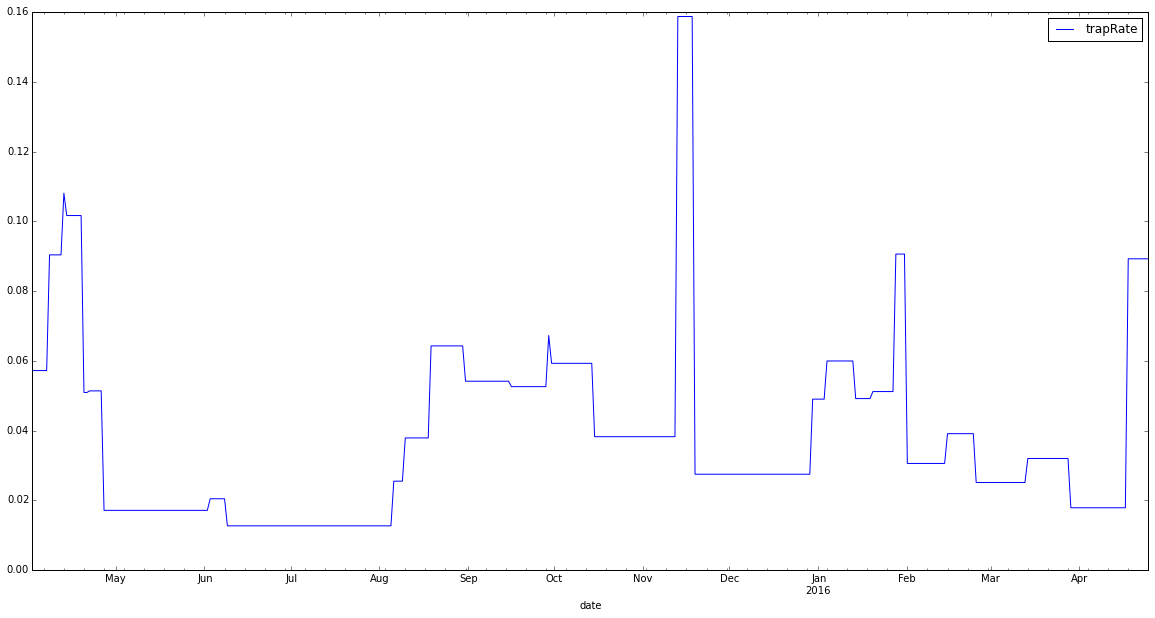

In [50]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

dfx.plot(y='trapRate')

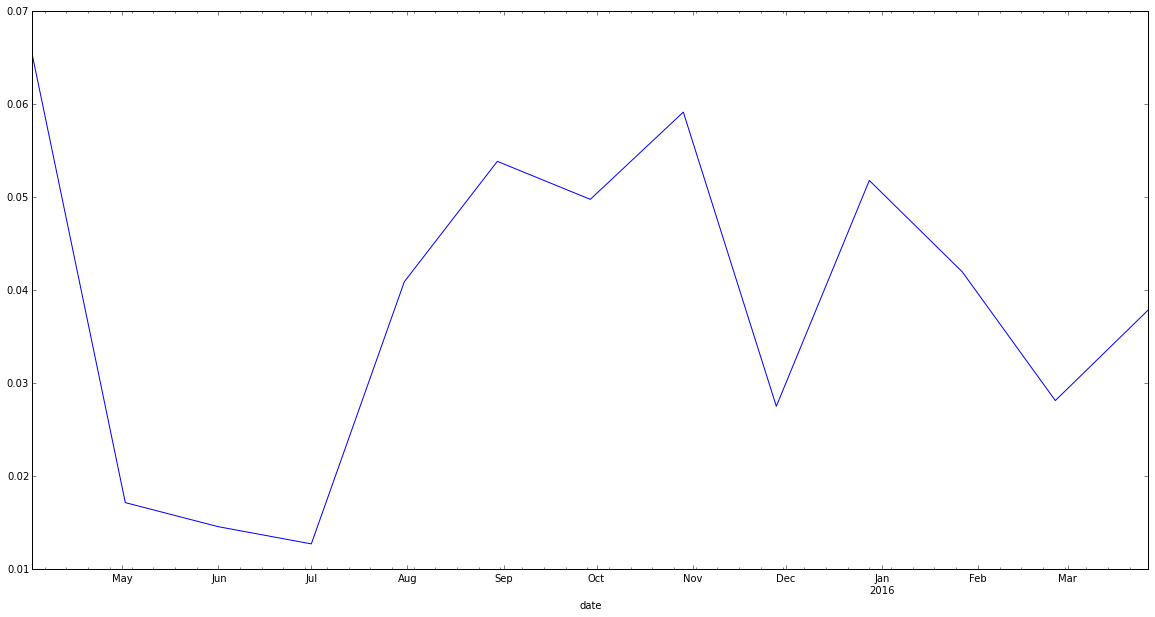

In [51]:
dfx.index = pd.to_datetime(dfx.index)
df = pd.rolling_mean(dfx['trapRate'], window=1,  freq='30d')
df.plot()

###To start, let's do a plot of total beetles

In [52]:
def slicer(endDate, daysPrior, df_daily = df_daily):
    '''
    Returns a data frame containing all records from df_daily
    where dates range from (endDate - daysPrior) to (endDate - 1)
    '''
#    d2 = datetime.datetime.strptime(endDate, '%Y-%m-%d')
    d2 = endDate
    d1 = d2 - datetime.timedelta(days=daysPrior)
    grouped = df_daily[(df_daily['date'] >= d1) & (df_daily['date'] < d2)].groupby('trap_id')
    df = grouped.aggregate(np.mean)
    return df

In [53]:
def mask_outside_polygon(poly_verts, ax=None):
    """
    Plots a mask on the specified axis ("ax", defaults to plt.gca()) such that
    all areas outside of the polygon specified by "poly_verts" are masked.  

    "poly_verts" must be a list of tuples of the verticies in the polygon in
    counter-clockwise order.

    Returns the matplotlib.patches.PathPatch instance plotted on the figure.
    """
    import matplotlib.patches as mpatches
    import matplotlib.path as mpath

    if ax is None:
        ax = plt.gca()

    # Get current plot limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Verticies of the plot boundaries in clockwise order
    bound_verts = [(xlim[0], ylim[0]), (xlim[0], ylim[1]), 
                   (xlim[1], ylim[1]), (xlim[1], ylim[0]), 
                   (xlim[0], ylim[0])]

    # A series of codes (1 and 2) to tell matplotlib whether to draw a line or 
    # move the "pen" (So that there's no connecting line)
    bound_codes = [mpath.Path.MOVETO] + (len(bound_verts) - 1) * [mpath.Path.LINETO]
    poly_codes = [mpath.Path.MOVETO] + (len(poly_verts) - 1) * [mpath.Path.LINETO]

    # Plot the masking patch
    path = mpath.Path(bound_verts + poly_verts, bound_codes + poly_codes)
    patch = mpatches.PathPatch(path, facecolor='white', edgecolor='none')
    patch = ax.add_patch(patch)

    # Reset the plot limits to their original extents
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    return patch


In [54]:
def plotmap(df, cmap):
    #df = slicer('2015-05-01', 90)
    #NOTE: Need to try colormesh. Faster than colrbar??
    x = df.easting.values
    y = df.northing.values
    values = df.trapRate.values
    vmin = 0.0
    vmax = max_trap_catch_scale
    
    # CAN WE REUSE THESE OBJECTS?
    #Creating the output grid (100x100, in the example)  
    #tx = np.linspace(min(x)-50, max(x)+50, 100)  
    #ty = np.linspace(min(y)-50, max(y)+50, 100)
    tx = np.linspace(min_easting, max_easting, 100)
    ty = np.linspace(min_northing, max_northing, 100)   
    XI, YI = np.meshgrid(tx, ty)  

    #Creating the interpolation function and populating the output matrix value  
    rbf = Rbf(x, y, values, function='multiquadric', epsilon=epsilon)  
    ZI = rbf(XI, YI)  
    # Plotting the result  
    plt.figure(figsize=(10,10))
    plt.axes().set_aspect(1.0) 
        
#    plt.pcolor(XI, YI, ZI, vmin=vmin, vmax=vmax, cmap=cmap) 
#    plt.pcolormesh(XI, YI, ZI, vmin=vmin, vmax=vmax, cmap=cmap) 
    
#    plt.contourf(XI, YI, ZI, vmin=vmin, vmax=vmax, cmap=cmap)     
    plt.contourf(XI, YI, ZI, vmin=vmin, vmax=vmax, cmap=cmap, levels=levels, extend='both')     
    
    plt.colorbar(label='beetles per trap-day')
    myplot = plt.scatter(x, y, marker_size, values, vmin=vmin, vmax=vmax, cmap=cmap) 
    plt.xlabel('meters')
    plt.ylabel('meters')
    
    #plt.title('RBF interpolation')
    min_x = min_easting - margin * (max_easting - min_easting)
    max_x = max_easting + margin * (max_easting - min_easting)
    min_y = min_northing - margin * (max_northing - min_northing)
    max_y = max_northing + margin * (max_northing - min_northing)  
    plt.xlim(min_x, max_x)  
    plt.ylim(min_y, max_y)
       
#    plt.xlim(264000,275000)
#    plt.ylim(1490000,1500000)
    
    if mask_csv:
        plt.plot(df_poly.easting, df_poly.northing, linewidth=2, color='black')
    #plt.colorbar()
    if show_trap_labels: 
        for index, row in df.iterrows():
            plt.annotate(
                index, 
                xy = (row.easting, row.northing), xytext = (0, 12),
                textcoords = 'offset points', ha = 'right', va = 'bottom',
                bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 0.30))
    if mask_csv:
        mask_outside_polygon(myp)
    return myplot  

In [55]:
def date_list(d1, d2):
    """
    Returns list containing first date in month from d1 to d2 
    """
    dlist = []
    for year in range(d1.year, d2.year+1):
        for month in range(1,13):
            d = date(year, month, 1)
            if (d >= d1) & (d <= d2):
                dlist.append(date(year, month, 1))
    return dlist

In [56]:
def plot_bars():
    colors = []
    for i in trapRateMeans:
        colors.append('white')

    for i in range(len(trapRateMeans)):
        colors[i] = 'red'
        fig = plt.figure()
        plt.bar(left=np.arange(len(plot_dates)), height=trapRateMeans, color=colors)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')  # labels along the bottom edge are off
        filename = 'bars%s.png' % (plot_dates[i].strftime('%Y-%m-%d'))
        colors[i] = 'white'
        #xmin, xmax = plt.xlim()
        #plt.text(xmin, -0.0002, d1)
        #plt.text(xmax-1, -0.0002, d2)
        plt.ylabel('beetles per trap-day')
        plt.title('Mean Islandwide Trap Catch')
        fig.savefig(filename)

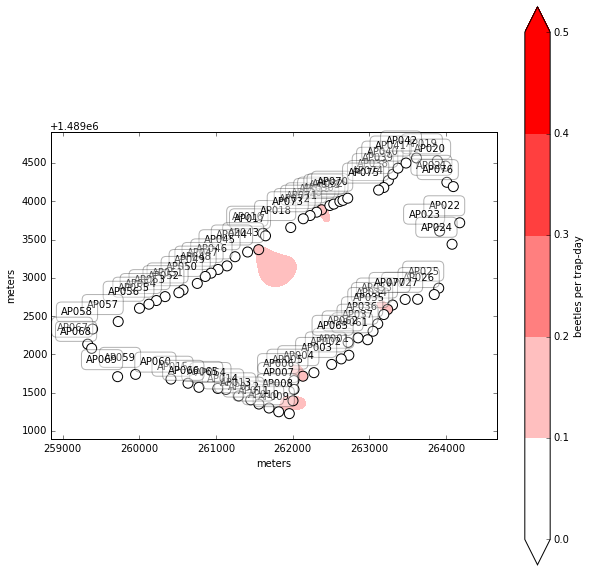

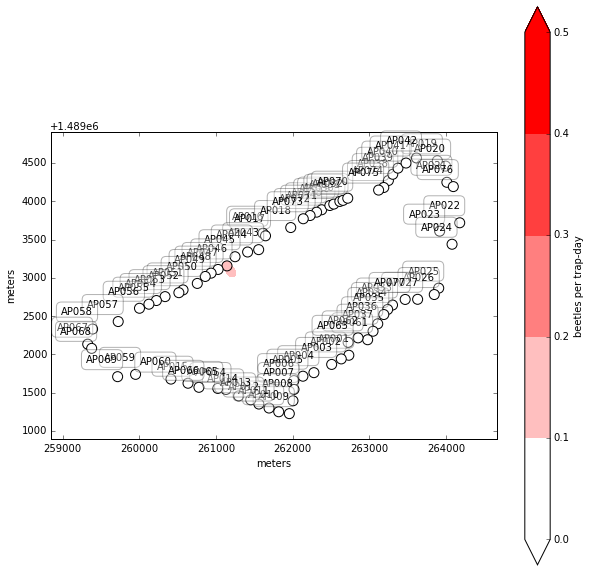

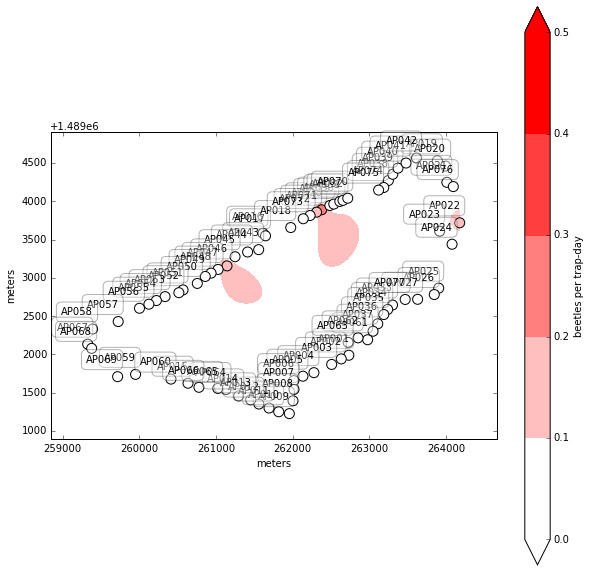

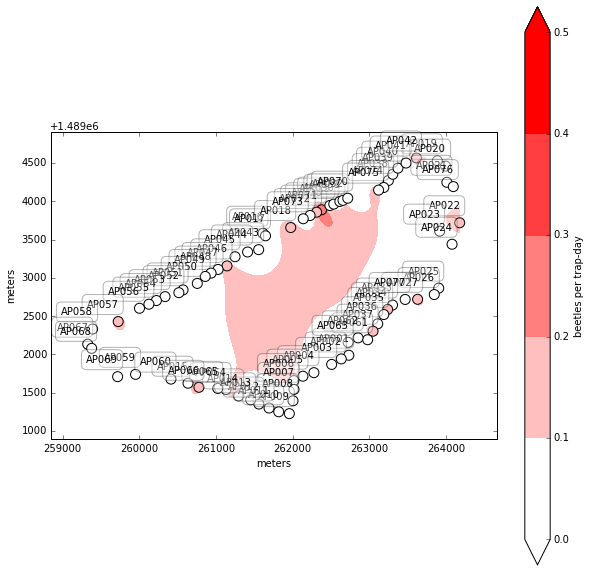

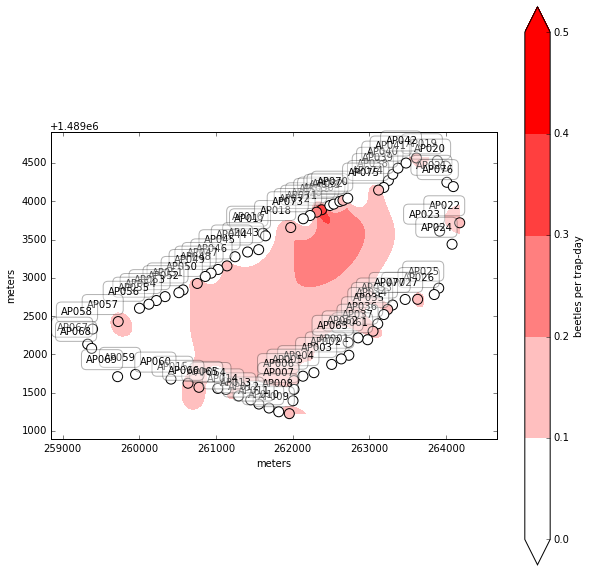

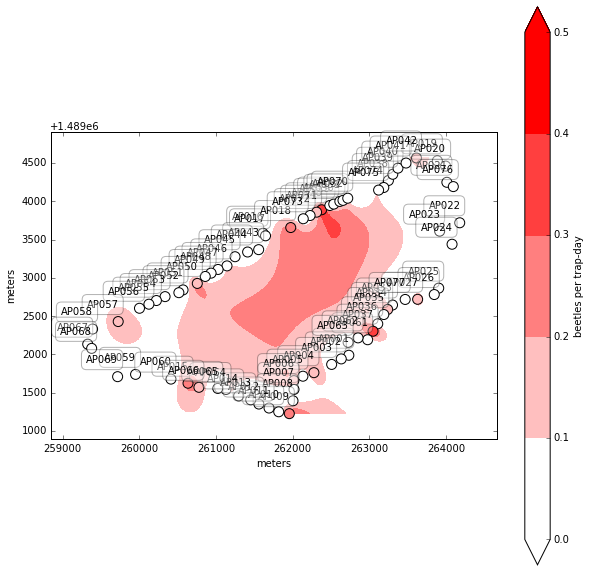

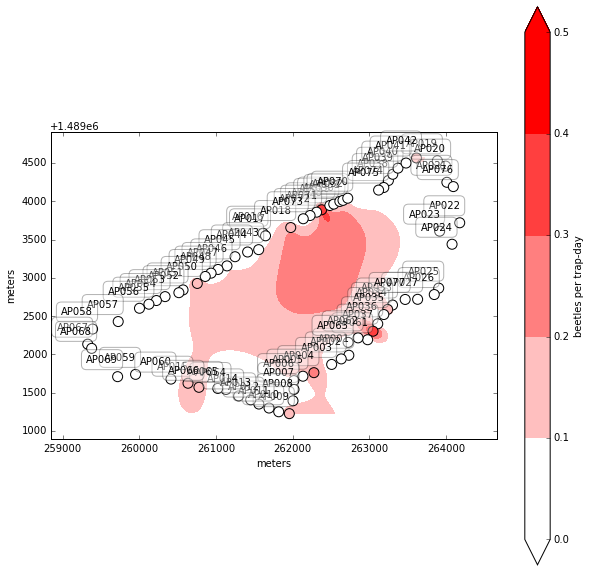

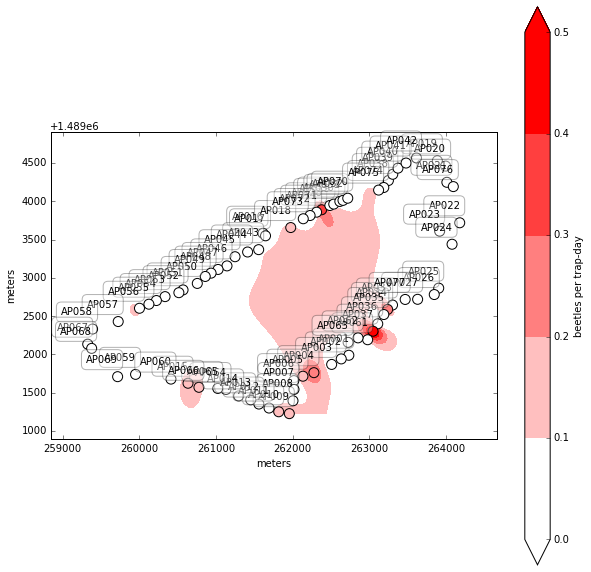

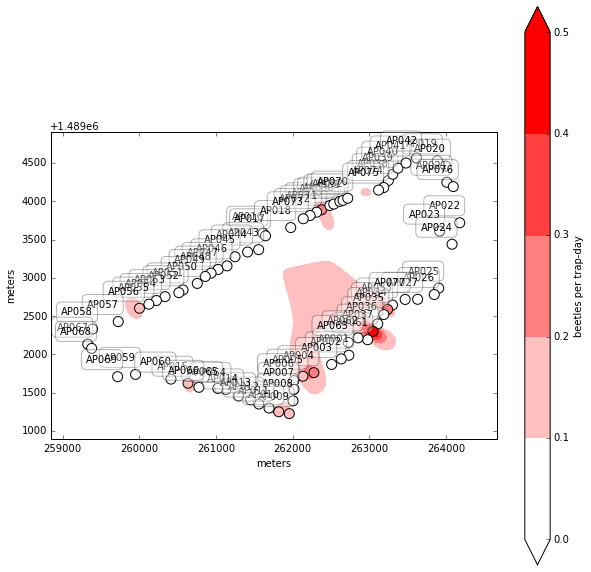

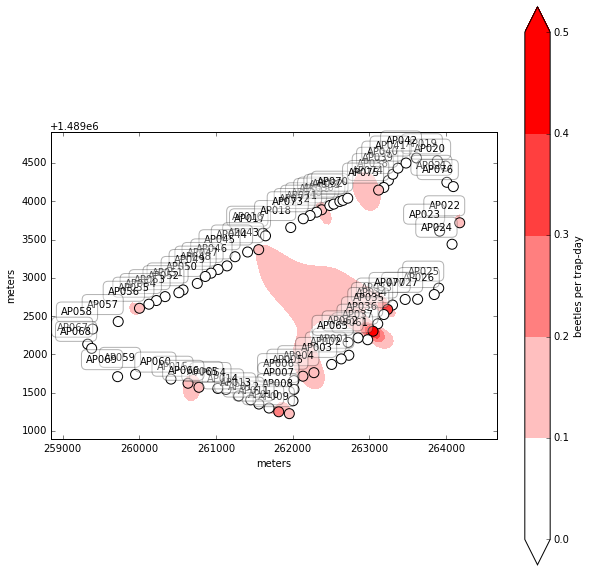

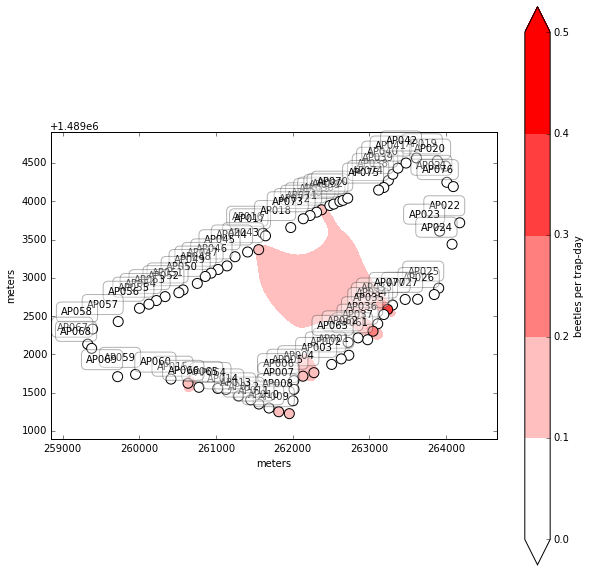

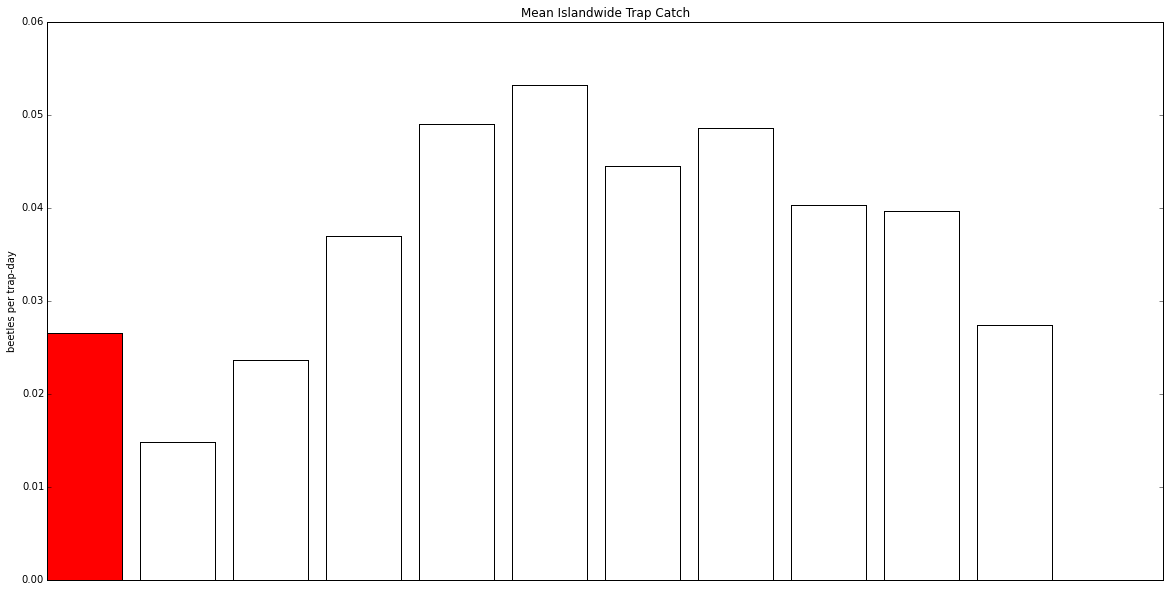

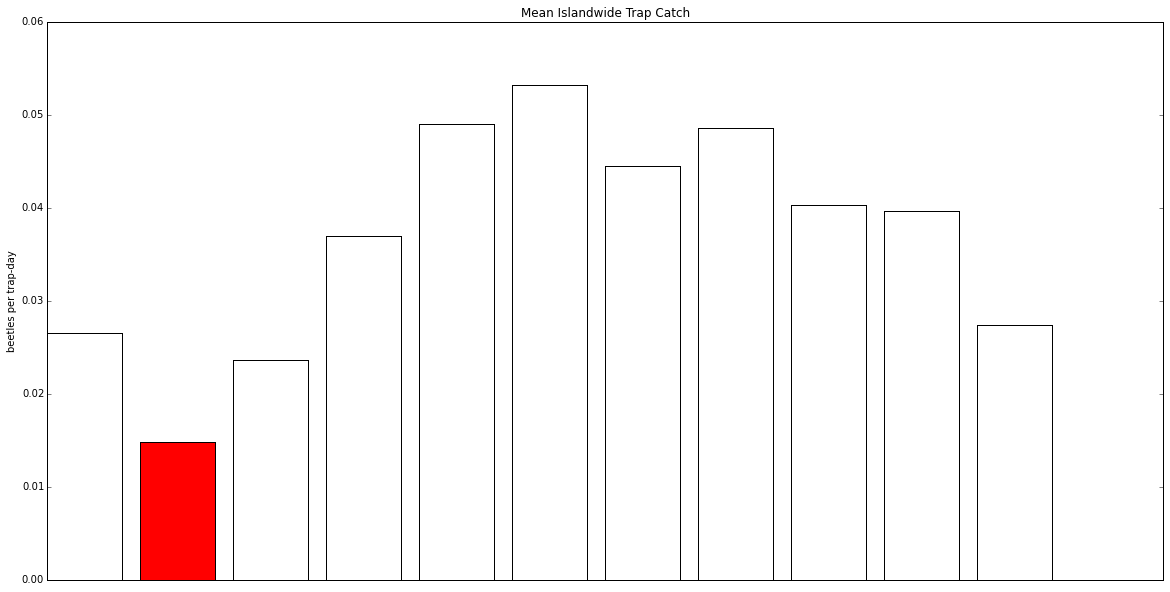

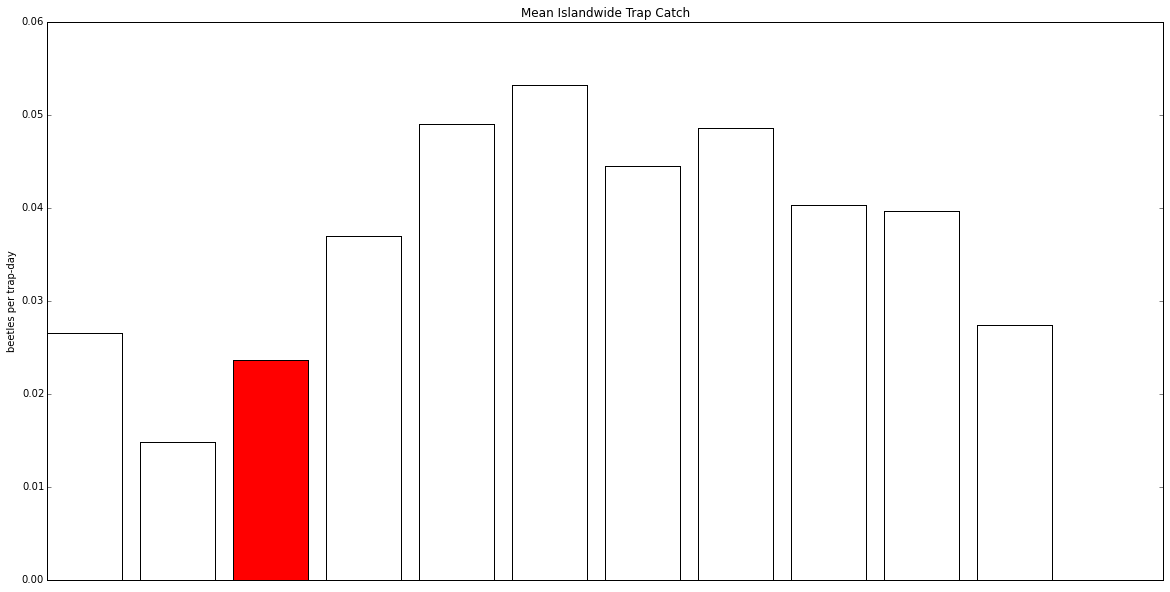

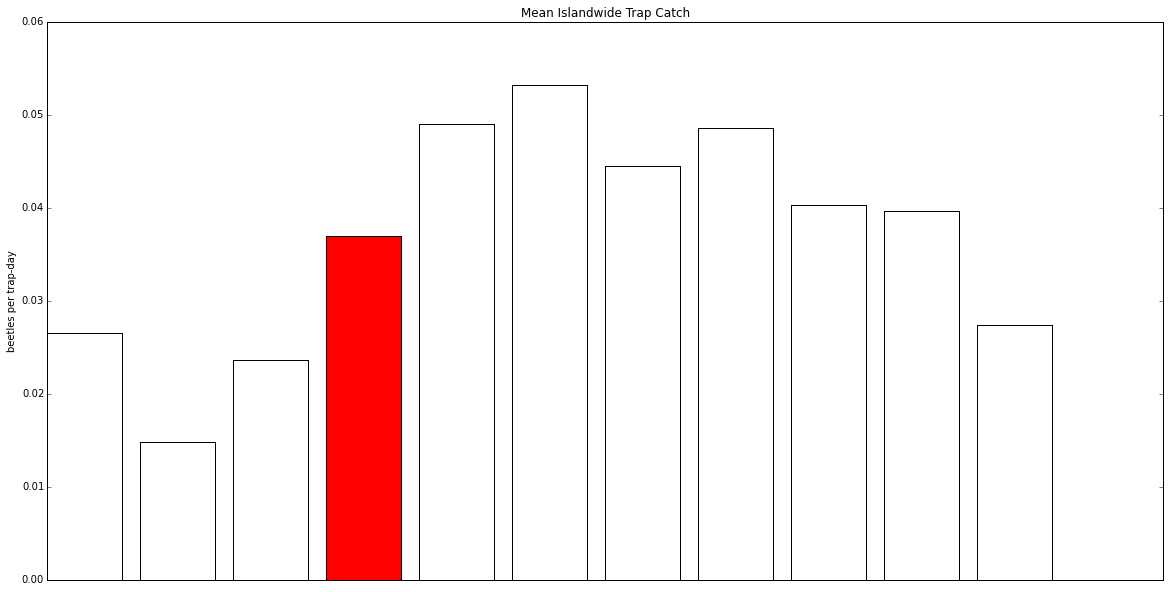

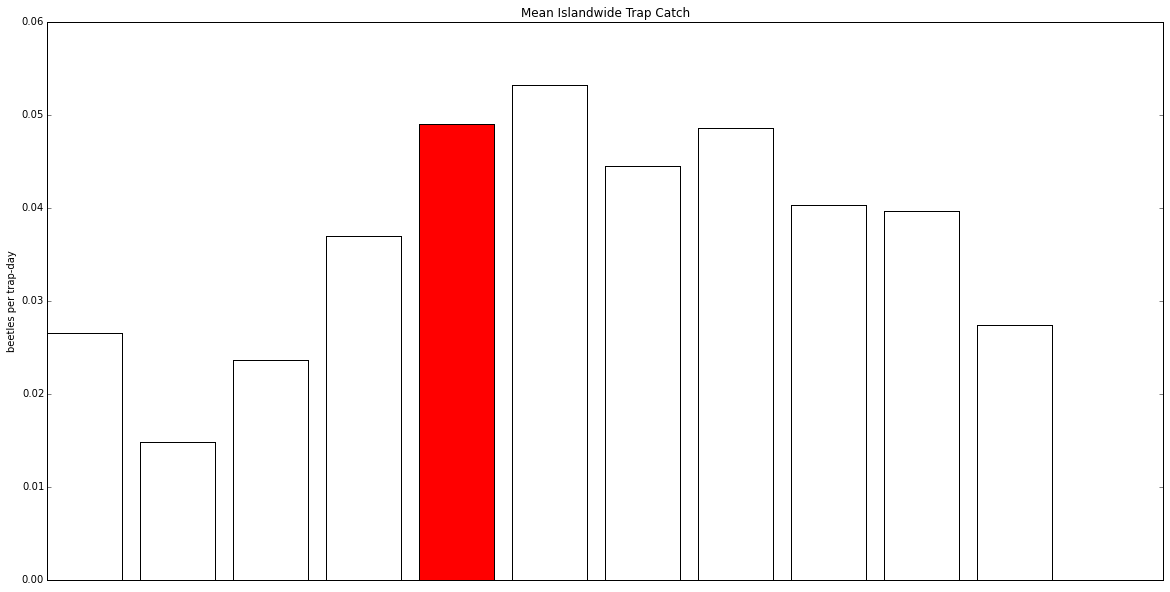

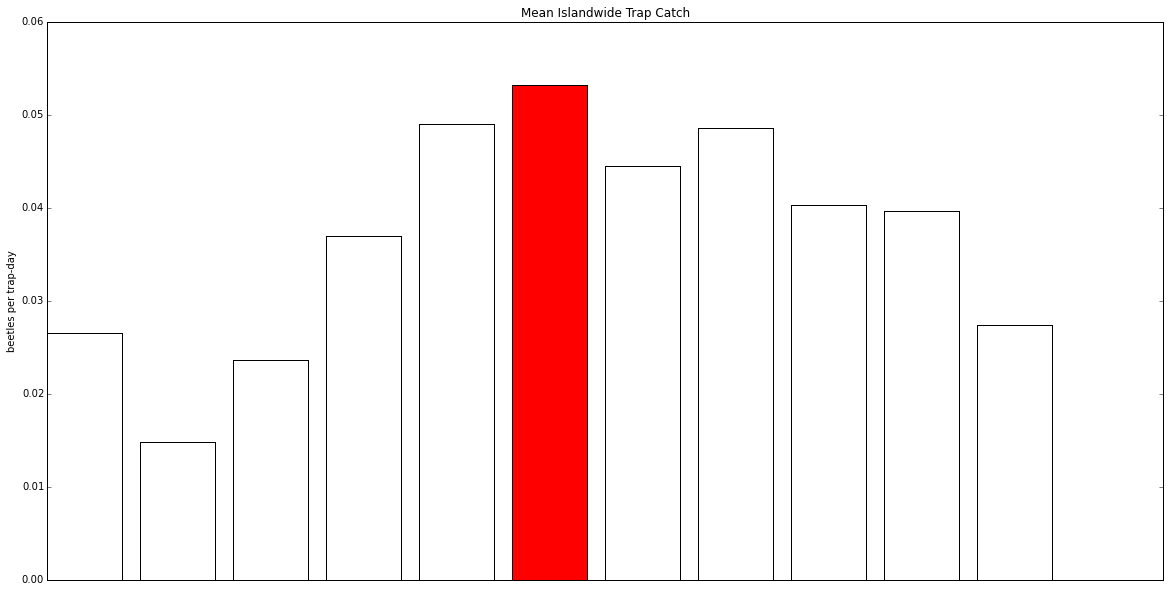

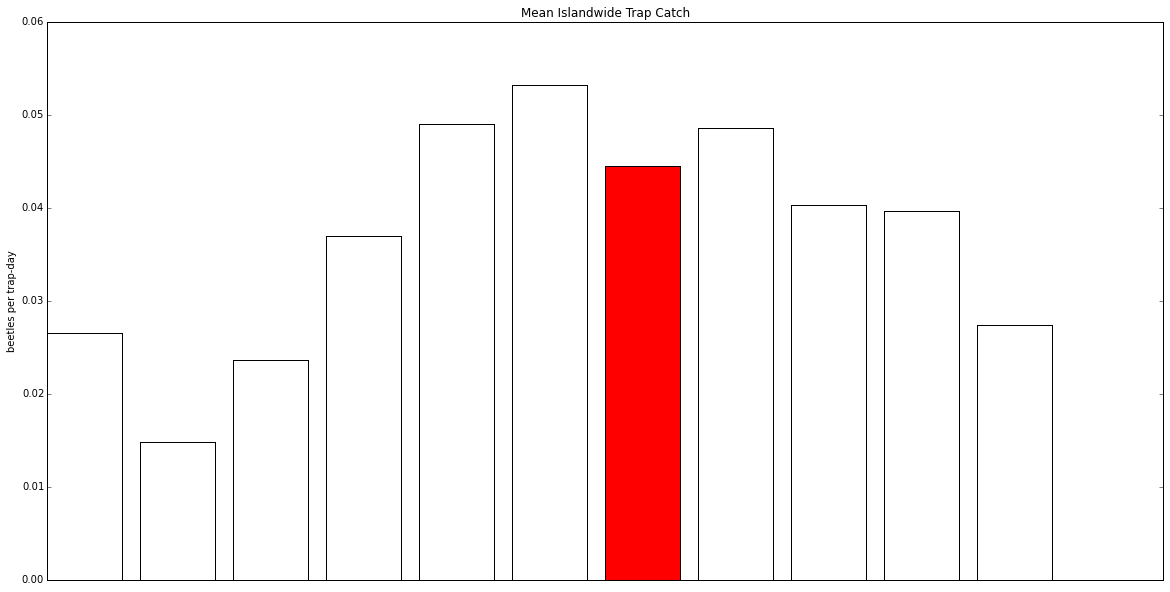

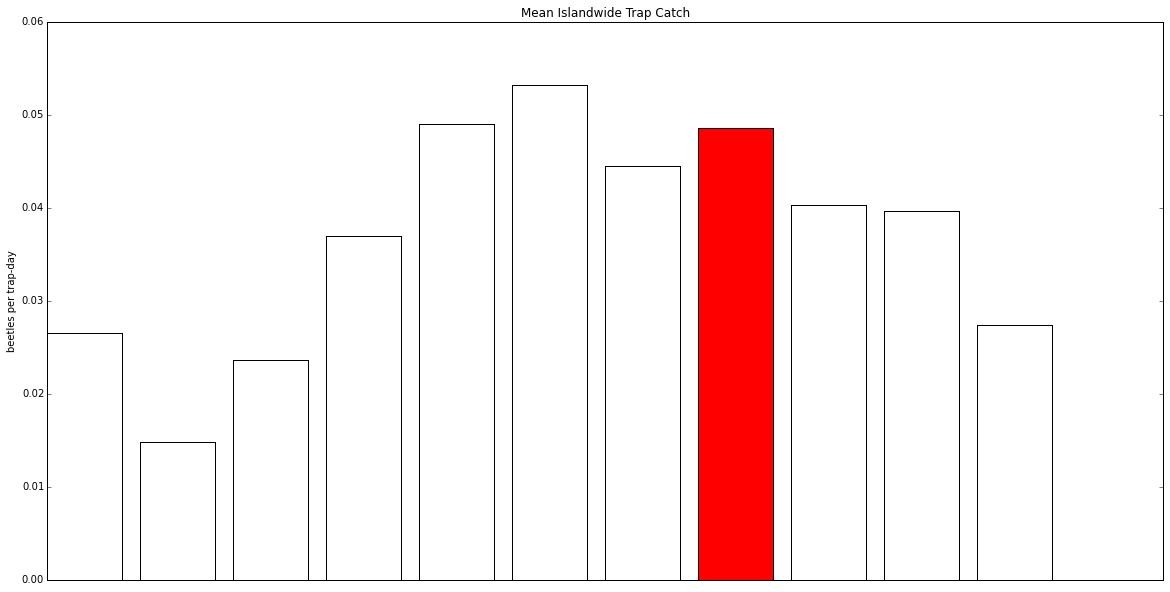

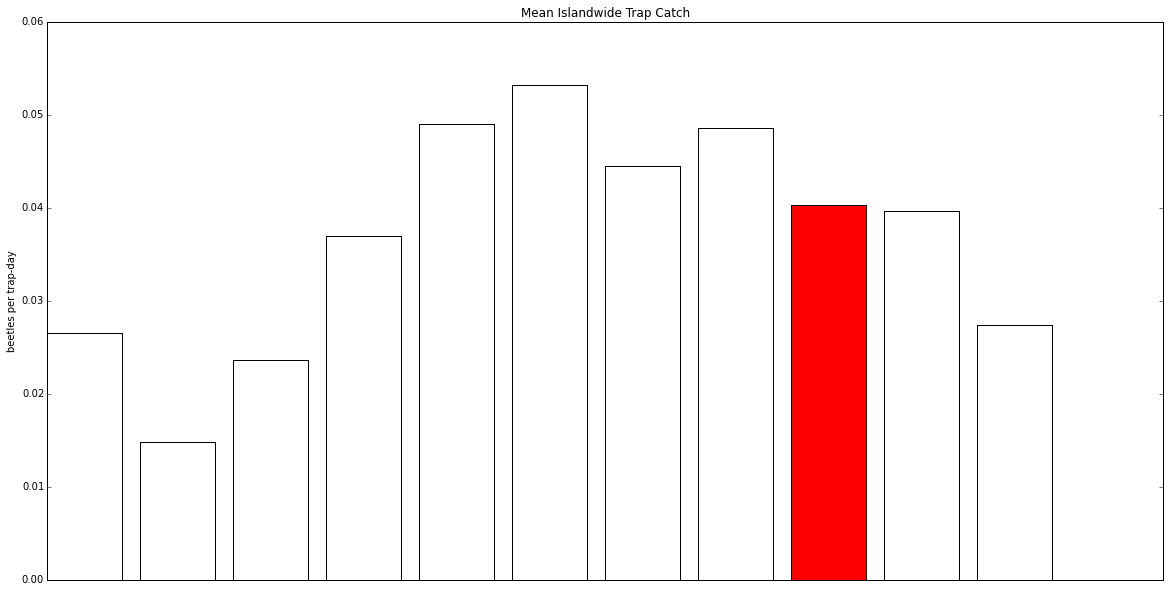

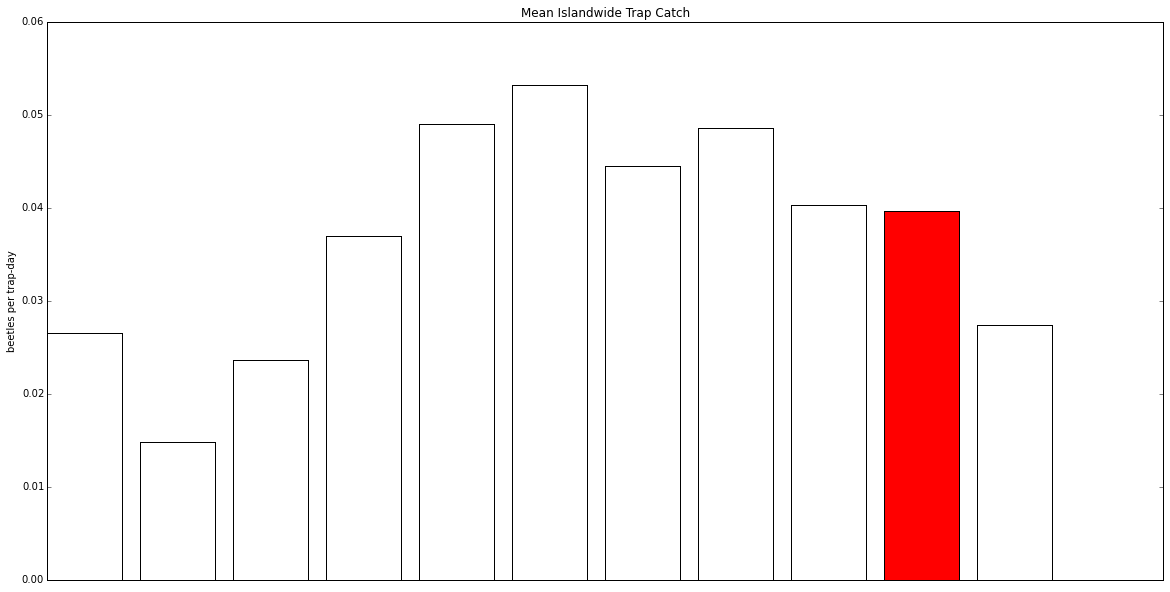

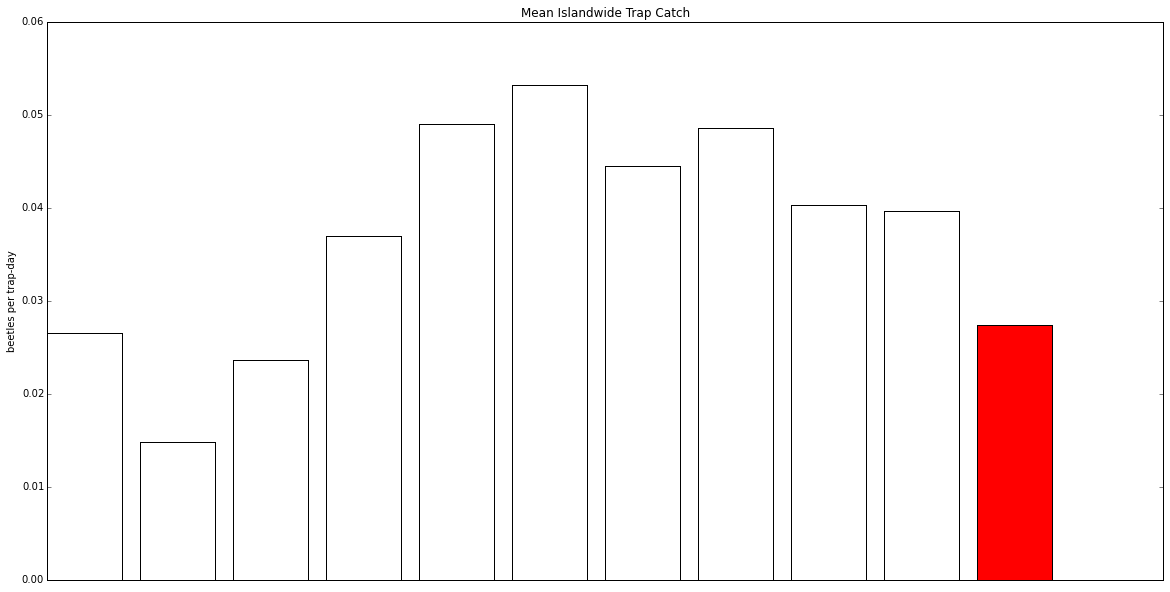

In [57]:
cmap = generate_red_colormap()
cmap = cmap_discretize(cmap, 5)

plot_dates = date_list(d1, d2)
trapRateMeans = []
for endDate in plot_dates:
    df = slicer(endDate, 90)
   
    #print(df[df.duplicated(['easting','northing'])])
          
    myplot = plotmap(df, cmap)
    myplot.figure.savefig(endDate.strftime('%Y-%m-%d') + '.png')
    trapRateMeans.append(np.mean(df.trapRate))
    
#    df.to_json(endDate.strftime('%Y-%m-%d') + '.json')
       
plot_bars()

In [ ]:
title = r'Visualization of Guam Coconut Rhinoceros Beetle Trap Data\\Port Authority (PA) Traps'

tex = r'''
\documentclass{beamer}
\usepackage[export]{adjustbox}% http://ctan.org/pkg/adjustbox
\setbeamersize{text margin left=1cm,text margin right=1cm}
'''
tex += r'\title{' + title + r'}'
tex += r'''
%\title{' + title + ''}'
%\titlehead{Guam Coconut Rhinoceros Project Technical Report\\DRAFT: Work in progress}
%\title{Visualization of Pan Trap Data at the University of Guam Yigo Agricultural Experiment Station}
%\title{Visualization of Guam Coconut Rhinoceros Beetle Trap Data\\Port Authority (PA) Traps}

\author{Aubrey Moore}

\begin{document}
\frame{\titlepage}

\begin{frame}{Notes}
\begin{itemize}
    \item Best viewed in with a PDF reader in presentation mode.
    \item This document was generated by an IPython Notebook.
    \item Data required:
    \begin{itemize}
        \item a CSV table containing 3 fields: trap identifier and lat/long coordinates in decimal degrees
        \item a CSV table containing 4 fields: trap identifier, dates for start and end of trapping period, 
and number of beetles trapped during the trapping period
        \item a CSV table containing 2 fields: lat/long coordinates in decimal degrees defining a mask for the region of interest
    \end{itemize}
\end{itemize}
\end{frame}

'''
for d in plot_dates:
#    tex += r'\begin{frame}{Yigo Pan Traps: mean beetles per trap-day for 90 day period ending \textbf{%s}}' % d.strftime('%d %b %y') + '\n'
    tex += r'\begin{frame}{Mean beetles per trap-day for 90 day period ending\\ \textbf{%s}}' % d.strftime('%d %b %Y') + '\n'
    tex += r'\includegraphics[width=0.6\linewidth,valign=c]{%s.png}' % d.strftime('%Y-%m-%d') + '\n'
    tex += r'\includegraphics[width=0.4\linewidth,valign=c]{bars%s.png}' % d.strftime('%Y-%m-%d') + '\n'
    tex += r'\end{frame}' + '\n'
tex += r'\end{document}' 

#print(tex)
f = open("template.tex", "w")
f.write(tex)
f.close()

In [ ]:
%%bash
pdflatex template.tex 
mv template.pdf trapviz.pdf
xdg-open trapviz.pdf

# Make a movie

In [ ]:
%%bash

# Uncomment below to make an mpg movie file

gs -q -dBATCH -dNOPAUSE -sDEVICE=png16m -r300 -sOutputFile="tm%d.png" "trapviz.pdf"
avconv -y -r 1 -f image2 -i tm%d.png -r 25 -c:v mpeg2video trapviz.mpg

# Garbage collection

In [ ]:
%%bash
rm template.*
rm *.png

In [ ]:
df_obs.end_date.max()